In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import pdb
from scipy.stats import kurtosis
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
from scipy.stats import chi2
import pandas as pd
import iris
from scipy.stats import gaussian_kde
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial.distance import mahalanobis, pdist, squareform
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copulas.multivariate import GaussianMultivariate

# import functions
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures,fidelity_testing_compare


# 1. Load data

In [2]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_pr_model_DePreSys4.nc'  
model4 = nc.Dataset(file_path, mode='r')

pr_model4 = model4.variables['unknown'][:]
pr_model4.shape
model4.variables.keys()

dict_keys(['unknown', 'leadtime', 'year', 'realisation', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'month_number', 'month_number_bnds'])

In [3]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_model_DePreSys4.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model4 = summer_tem_model.variables['tas'][:]
summer_tem_model.variables.keys()

dict_keys(['tas', 'leadtime', 'year', 'realisation', 'height', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'month_number', 'month_number_bnds'])

In [4]:
# new reshape simulations from 3 dimensions to 2 dimensions
def new_reshape_model(simulations):  
    # reshape model simulations
    n_years = simulations.shape[1]  
    n_months = simulations.shape[2]  
    new_model = np.transpose(simulations[:], (1, 0, 2))
    new_model = new_model.reshape(n_years, -1)
    return new_model

In [5]:
# univariate data
pr_mod4 = new_reshape_model(pr_model4)
tem_mod4 = new_reshape_model(tem_model4)

In [6]:
pr_mod4.shape

(30, 100)

In [7]:
# load obs data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_pr_obs_ERA5-Land.nc'  
summer_pr_obs = nc.Dataset(file_path, mode='r')
summer_pr_obs.variables.keys()
pr_obs = summer_pr_obs.variables['tp'][:]
pr_obs.shape

(30,)

In [8]:
# load obs data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_obs_ERA5-Land.nc'  
summer_tem_obs = nc.Dataset(file_path, mode='r')
summer_tem_obs.variables.keys()
tem_obs = summer_tem_obs.variables['t2m'][:]
tem_obs.shape

(30,)

In [9]:
# create cube for plotting
def convert_array_cube(data):
    time_coord = coords.DimCoord(range(data.shape[0]), standard_name='time')
    if data.ndim > 1:
        year_coord = coords.DimCoord(range(data.shape[1]), standard_name='realization')
        # define units for each coord
        year_coord.units = cf_units.Unit('years since 1992', calendar='gregorian')
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
    else:
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0)])
    cube.long_name = 'Hunan_Summer_data'
    cube.units = 'celsius'
    return cube


In [10]:
# cube univariate data:
pr4 = convert_array_cube(pr_mod4)
temp4 = convert_array_cube(tem_mod4)

In [11]:
temp4.shape

(30, 100)

## 1. Map

In [12]:
def plotting_obs_mod(obs, mod, mod_corrected):
    obs_data = obs.data
    mod_data = mod.data
    mod_corrected_data = mod_corrected
    years = np.arange(1992, 2022)
    mod_mean = mod_data.mean(axis=1)
    mod_std = mod_data.std(axis=1)   
    mod_corrected_mean = mod_corrected_data.mean(axis=1)
    mod_corrected_std = mod_corrected_data.std(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_data.shape[1]):
        axes[0].plot(years, mod_data[:, i], color='grey', alpha=0.2)
    axes[0].plot(years, mod_mean, label='DePreSys4_mean', color='red', linewidth=2, linestyle='--')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Temperature')
    axes[0].set_title('Original Model')
    axes[0].legend()
    axes[1].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_corrected_data.shape[1]):
        axes[1].plot(years, mod_corrected_data[:, i], color='grey', alpha=0.2)
    axes[1].plot(years, mod_corrected_mean, label='DePreSys4_corrected_mean', color='blue', linewidth=2, linestyle='--')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Temperature')
    axes[1].set_title('Corrected Model')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [13]:
def mean_bias_correction(obs, model):
    """
    Perform mean bias correction on the model data.
    
    Parameters:
    obs (np.array): Observed values, shape (n_months,)
    model (np.array): Model forecast values, shape (n_ensembles, n_months)
    
    Returns:
    np.array: Bias-corrected model values, same shape as input model
    """
    # Calculate the mean across all ensembles and months
    model_mean = np.mean(model)
    obs_mean = np.mean(obs)
    
    # Calculate the correction factor
    correction_factor = obs_mean - model_mean
    
    # Apply the correction factor to the model data
    model_biascor = model + correction_factor
    
    return model_biascor


model4_meancor_pr= mean_bias_correction(pr_obs, pr_mod4)
model4_meancor_tem= mean_bias_correction(tem_obs, tem_mod4)

Hunan Summer Precipitation for DePreSys4 Data:


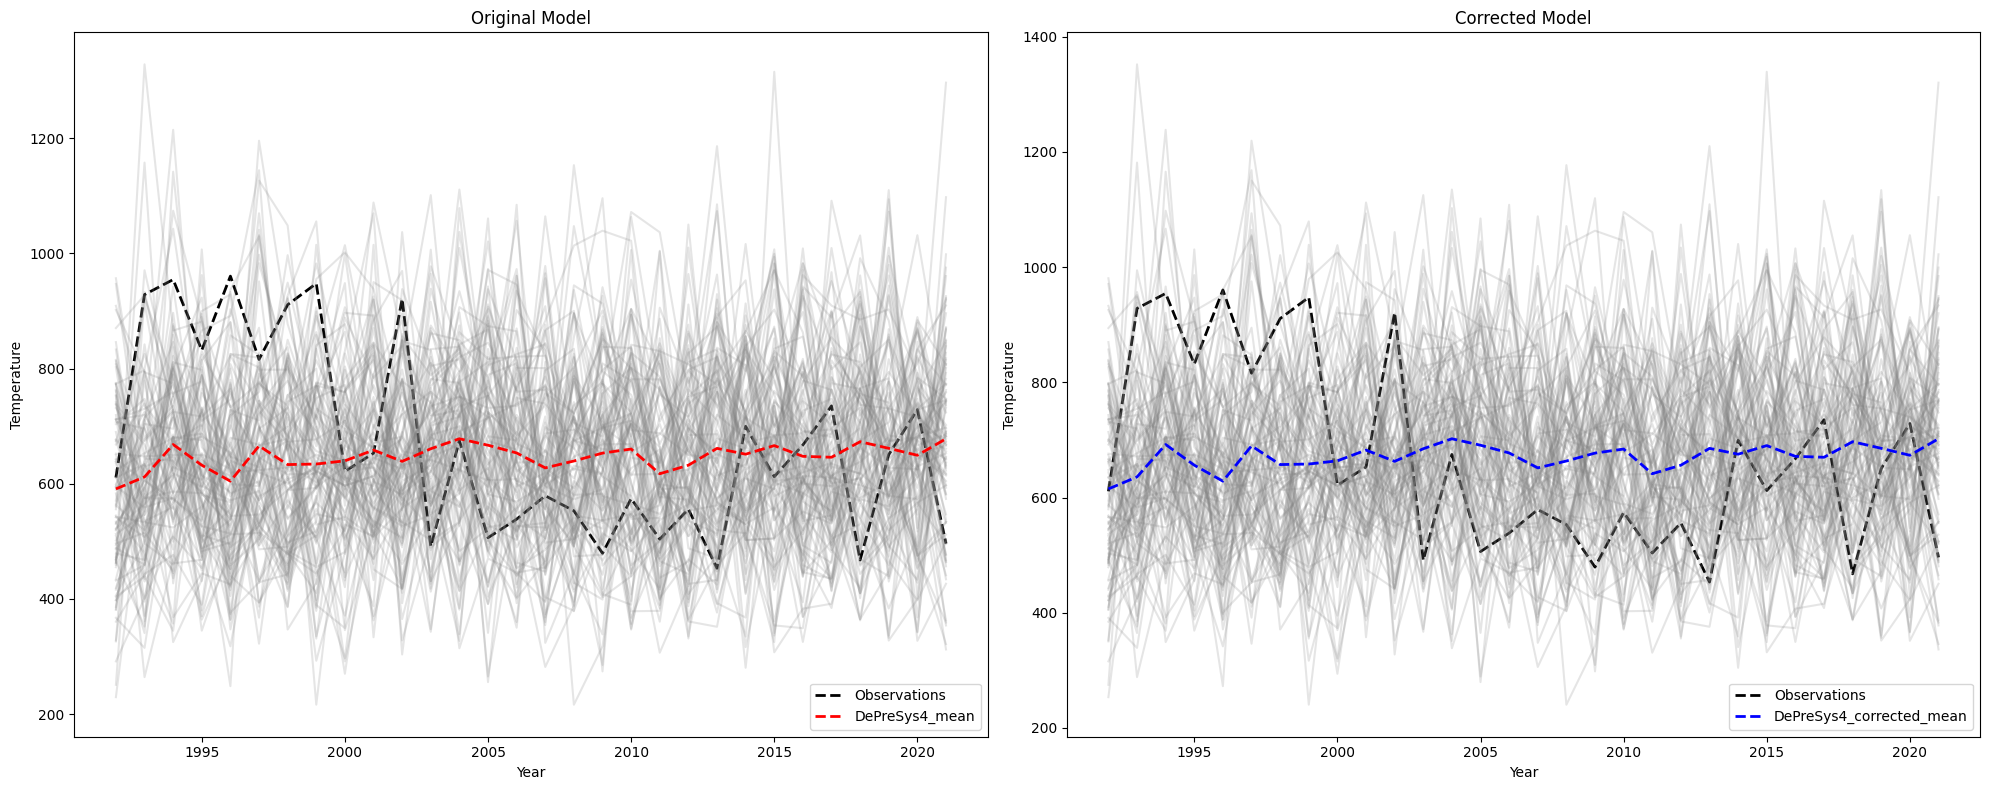

In [14]:
print("Hunan Summer Precipitation for DePreSys4 Data:")
plotting_obs_mod(pr_obs, pr_mod4, model4_meancor_pr)

Hunan Summer Temperature for DePreSys4 Data:


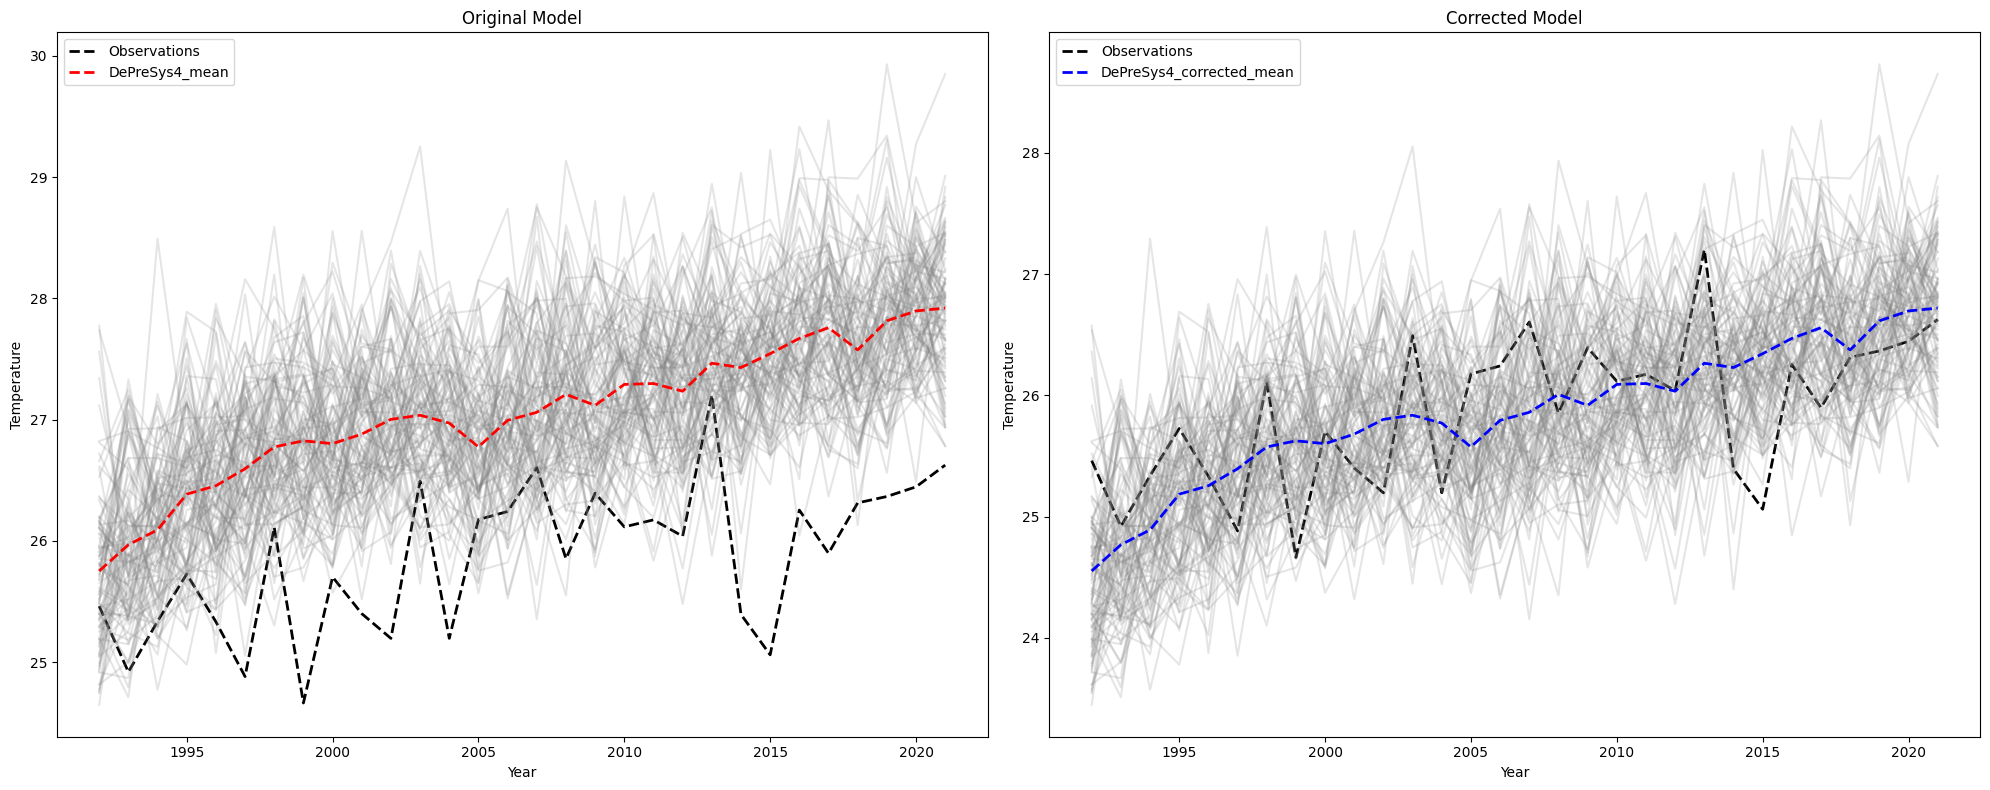

In [15]:
print("Hunan Summer Temperature for DePreSys4 Data:")
plotting_obs_mod(tem_obs, tem_mod4, model4_meancor_tem)

## Fidelity tesing using the traditional way

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 80.06
Standard deviation perc: 63.41
Skewness perc: 76.25
Kurtosis perc: 5.18
Linear trend perc: 0.02
plotting


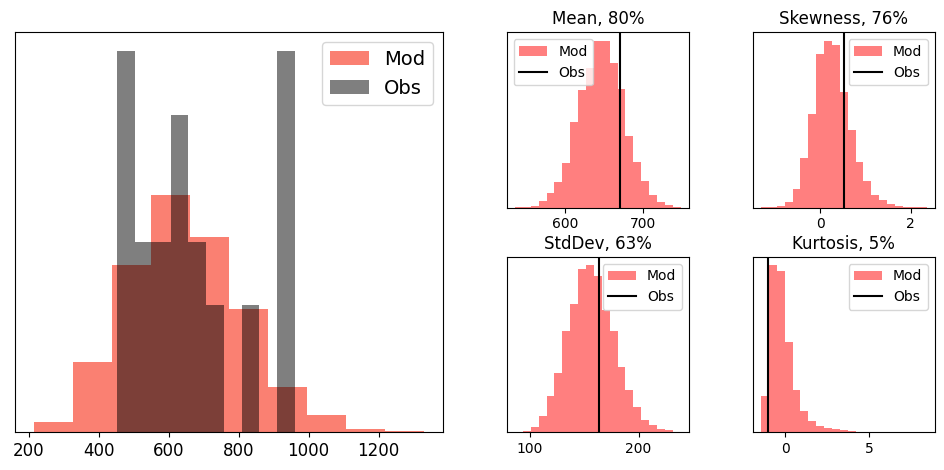

In [16]:
stats_measures_pr=timeseries_fid_test(pr_obs,pr_mod4)
plot_fidelity_testing(pr_obs, pr_mod4, stats_measures_pr, 0.1,"","1.png")

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 1.58
Skewness perc: 54.7
Kurtosis perc: 21.34
Linear trend perc: 5.54
plotting


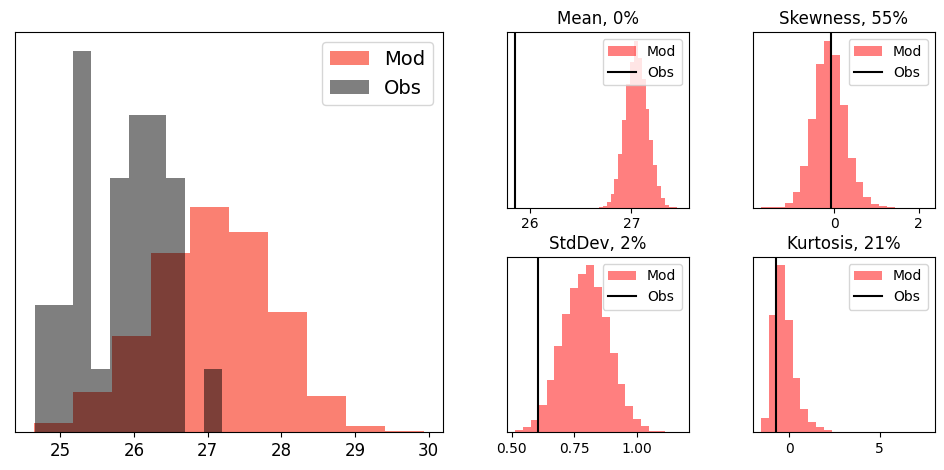

In [17]:
# temperature 
stats_measures_temp=timeseries_fid_test(tem_obs,tem_mod4)
plot_fidelity_testing(tem_obs,tem_mod4, stats_measures_temp, 0.1,"","1.png")

In [18]:
modraw_mean_boost=stats_measures_temp[1]["mean"]
print("original model mean (100 sample)", np.mean(tem_mod4))
print("boostrapped corrected model mean (10000 sample):",np.mean(modraw_mean_boost))
print("observed mean",tem_obs.mean())

original model mean (100 sample) 27.05304104789102
boostrapped corrected model mean (10000 sample): 27.052822501041334
observed mean 25.852407660620063


## Mean shift bias correction

In [19]:
pr_modcor4= mean_bias_correction(pr_obs, pr_mod4)
tem_modcor4= mean_bias_correction(tem_obs, tem_mod4)
print("mod mean:",tem_mod4.mean())
print("mod_cor mean:",tem_modcor4.mean())
print("obs mean",tem_obs.mean())

mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063


In [20]:
obs = np.column_stack((pr_obs, tem_obs))  # (30, 2)
modcor = np.array([pr_modcor4, tem_modcor4])  # (2, 30, 100)
modcor.shape

(2, 30, 100)

## Multivariate Data

1. mod_raw : Original model data
2. mod_cor : Mean shift model data
3. mod_corrected_eigen : mean and correlation corrected data

In [21]:
# 1. combine obs 
obs_combined = np.column_stack((pr_obs, tem_obs))
print("Combined obs shape:", obs_combined.shape)  

# 2. combine model data
mod_cor = np.empty((30, 100, 2))
mod_cor[:, :, 0] = pr_modcor4
mod_cor[:, :, 1] = tem_modcor4
print("mod_cor shape:", mod_cor.shape) 

mod_raw = np.empty((30, 100, 2))
mod_raw[:, :, 0] = pr_mod4
mod_raw[:, :, 1] = tem_mod4
print("mod_raw shape:", mod_raw.shape)  

# 3. data
print("First few rows of obs_combined:")
print(obs_combined[:5])
print("\nFirst few rows of mod_cor (first ensemble member):")
print(mod_raw[:5, 0, :])
print("\nFirst few rows of mod_cor (first ensemble member):")
print(mod_cor[:5, 0, :])

Combined obs shape: (30, 2)
mod_cor shape: (30, 100, 2)
mod_raw shape: (30, 100, 2)
First few rows of obs_combined:
[[610.75448375  25.46136233]
 [928.35023211  24.91844687]
 [954.39857899  25.33658792]
 [831.77319426  25.72635202]
 [960.43293461  25.33295977]]

First few rows of mod_cor (first ensemble member):
[[565.36144135  25.81407608]
 [793.89862004  25.54639777]
 [325.02945739  26.47489339]
 [433.19272895  27.88966304]
 [807.61322803  27.72534923]]

First few rows of mod_cor (first ensemble member):
[[589.38358431  24.61344269]
 [817.920763    24.34576438]
 [349.05160035  25.27426   ]
 [457.21487191  26.68902966]
 [831.635371    26.52471584]]


In [22]:
# 4. statistical info
print("\nObservation statistics:")
print("Mean (pr, tas):", obs_combined.mean(axis=0))
print("Std (pr, tas):", obs_combined.std(axis=0))

print("\nModel statistics:")
print("Mean (pr, tas):", mod_cor.mean(axis=(0, 1)))
print("Std (pr, tas):", mod_cor.std(axis=(0, 1)))

print("\nModel statistics:")
print("Mean (pr, tas):", mod_raw.mean(axis=(0, 1)))
print("Std (pr, tas):", mod_raw.std(axis=(0, 1)))

# 5. correlation
obs_corr = np.corrcoef(obs_combined[:, 0], obs_combined[:, 1])[0, 1]
print("\nObservation correlation between pr and tas:", obs_corr)
mod_corrs = np.array([np.corrcoef(mod_cor[:, i, 0], mod_raw[:, i, 1])[0, 1] for i in range(80)])
print("Model_cor correlation range:", mod_corrs.min(), "to", mod_corrs.max())

mod_rawcor = np.array([np.corrcoef(mod_raw[:, i, 0], mod_raw[:, i, 1])[0, 1] for i in range(80)])
print("Model_raw correlation range:", mod_rawcor.min(), "to", mod_rawcor.max())


Observation statistics:
Mean (pr, tas): [670.68504816  25.85240766]
Std (pr, tas): [163.1468128002196 0.6074457891762629]

Model statistics:
Mean (pr, tas): [670.68504816  25.85240766]
Std (pr, tas): [160.47714763   0.80890722]

Model statistics:
Mean (pr, tas): [646.6629052   27.05304105]
Std (pr, tas): [160.47714763   0.80890722]

Observation correlation between pr and tas: -0.6896029292788531
Model_cor correlation range: -0.6131565554461835 to 0.1186886875416462
Model_raw correlation range: -0.6131565554461835 to 0.1186886875416462


## Comparison: Original model data vs. mean shift corrected model data

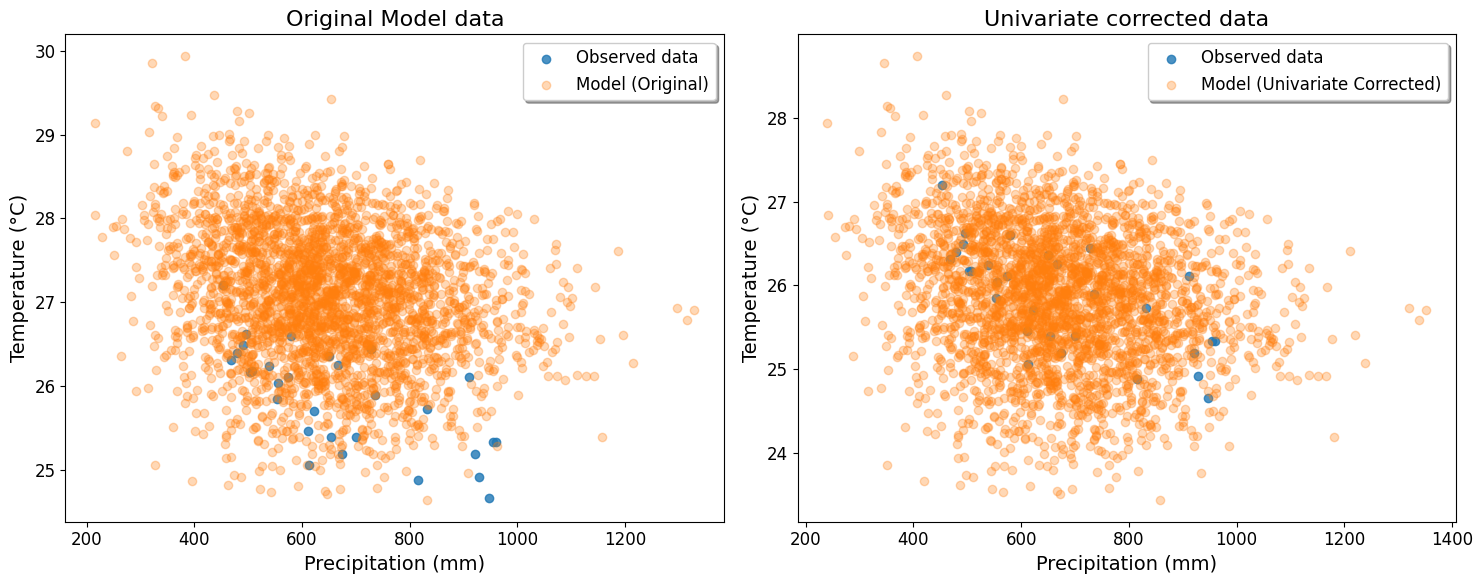

In [23]:
# univariate correction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax1.scatter(mod_raw[:, :, 0], mod_raw[:, :, 1], alpha=0.3, label='Model (Original)')
ax1.set_title('Original Model data', fontsize=16)
ax1.set_xlabel('Precipitation (mm)', fontsize=14)
ax1.set_ylabel('Temperature (°C)', fontsize=14)
ax1.legend(fancybox=True, frameon=True, shadow=True)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax2.scatter(mod_cor[:, :, 0], mod_cor[:, :, 1], alpha=0.3, label='Model (Univariate Corrected)')
ax2.set_title('Univariate corrected data', fontsize=16)
ax2.set_xlabel('Precipitation (mm)', fontsize=14)
ax2.set_ylabel('Temperature (°C)', fontsize=14)
ax2.legend(fancybox=True, frameon=True, shadow=True)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [24]:
tem_modcor4.shape

(30, 100)

## Fidelity testing using traditional mothod: mean shift corrected model data

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 49.669999999999995
Standard deviation perc: 1.7000000000000002
Skewness perc: 55.16
Kurtosis perc: 19.919999999999998
Linear trend perc: 5.390000000000001
plotting


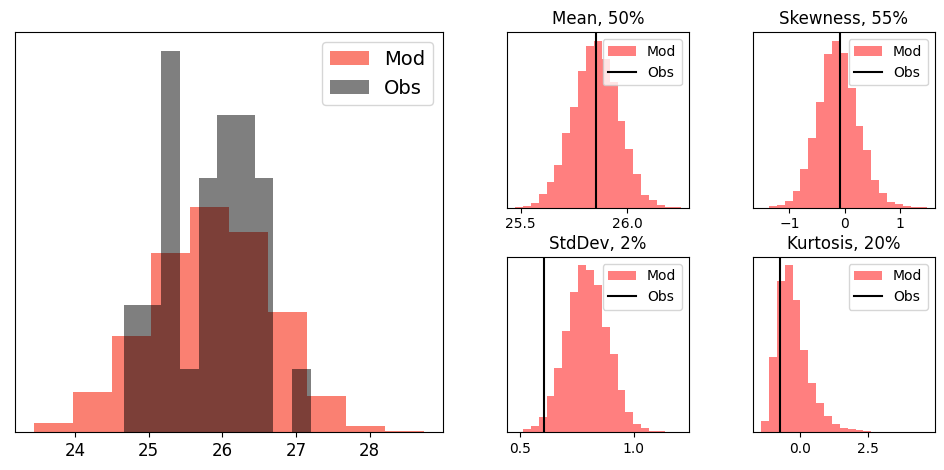

In [25]:
# temperature after mean shift
stats_measures_temp_meancor=timeseries_fid_test(tem_obs,tem_modcor4)
plot_fidelity_testing(tem_obs, tem_modcor4, stats_measures_temp_meancor, 0.1,"","1.png")

In [26]:
# fidelity test for original model data model:30*100 obs:30
mod_mean_boost=stats_measures_temp_meancor[1]["mean"]
print("original model mean (100 sample):", np.mean(tem_mod4))
print("corrected model mean (100 sample):", np.mean(tem_modcor4))
print("boostrapped corrected model mean (10000 sample):",np.mean(mod_mean_boost))
print("observed mean",tem_obs.mean())

original model mean (100 sample): 27.05304104789102
corrected model mean (100 sample): 25.852407660620063
boostrapped corrected model mean (10000 sample): 25.852755734534533
observed mean 25.852407660620063


## Bias Correction: mean and correlation correction

In [62]:
# correct mean and correlation, preserve the variance
def multi_correction_eigen_per_ensemble(mod, obs):
    n_years, n_ensembles, n_vars = mod.shape
    print(n_ensembles)
    mod_corrected = np.empty_like(mod)  
    obs_mean = np.mean(obs, axis=0)
    obs_std = np.std(obs, axis=0)
    obs_st = (obs - obs_mean) / obs_std
    Covariance_obs = np.cov(obs_st, rowvar=False)
    eigenvalues_obs, W = np.linalg.eigh(Covariance_obs)
    eigenvalues_obs = np.maximum(eigenvalues_obs, 1e-6)  

    for i in range(n_ensembles):
        mod_mean = np.mean(mod[:, i, :], axis=0)
        mod_std = np.std(mod[:, i, :], axis=0)
        mod_st = (mod[:, i, :] - mod_mean) / mod_std
        Covariance_mod = np.cov(mod_st, rowvar=False)
        eigenvalues_mod, V = np.linalg.eigh(Covariance_mod)
        eigenvalues_mod = np.maximum(eigenvalues_mod, 1e-6) 
        Gamma_inv_sqrt = np.diag(1.0 / np.sqrt(eigenvalues_mod))
        Lambda_sqrt = np.diag(np.sqrt(eigenvalues_obs))

        Zm = np.einsum('ij,jk->ik', mod_st, V)  # mod_st * V
        Zm = np.einsum('ik,kl->il', Zm, Gamma_inv_sqrt)  # * Gamma^-1/2
        Zm = np.einsum('il,lm->im', Zm, Lambda_sqrt)  # * Lambda^1/2
        Zm = np.einsum('im,mn->in', Zm, W.T)  # * W^T
        mod_corrected[:, i, :] = Zm * mod_std + obs_mean     
    return mod_corrected

mod_corrected_eigen = multi_correction_eigen_per_ensemble(mod_raw, obs_combined)

100


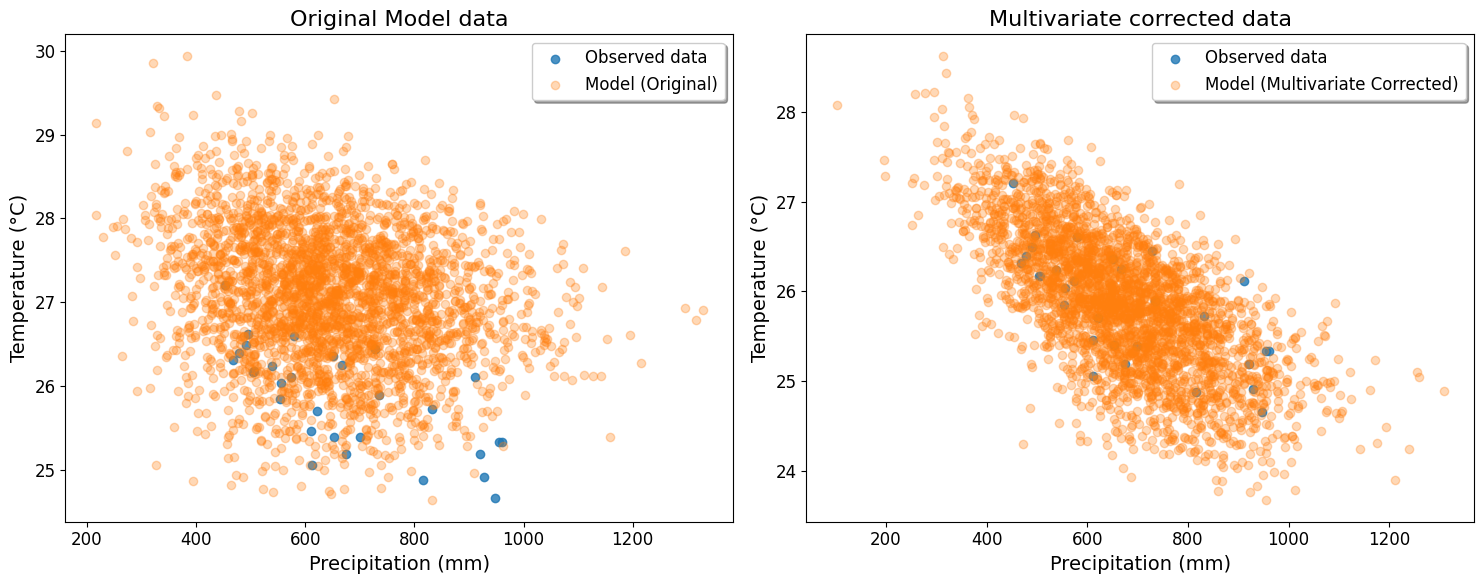

In [28]:
# multivariate correction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax1.scatter(mod_raw[:, :, 0], mod_raw[:, :, 1], alpha=0.3, label='Model (Original)')
ax1.set_title('Original Model data', fontsize=16)
ax1.set_xlabel('Precipitation (mm)', fontsize=14)
ax1.set_ylabel('Temperature (°C)', fontsize=14)
ax1.legend(fancybox=True, frameon=True, shadow=True)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax2.scatter(mod_corrected_eigen[:, :, 0], mod_corrected_eigen[:, :, 1], alpha=0.3, label='Model (Multivariate Corrected)')
ax2.set_title('Multivariate corrected data', fontsize=16)
ax2.set_xlabel('Precipitation (mm)', fontsize=14)
ax2.set_ylabel('Temperature (°C)', fontsize=14)
ax2.legend(fancybox=True, frameon=True, shadow=True)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


## Fidelity Testing for mean and correlation corrected data

In [29]:
def mardia_skewness_kurtosis(X):
    n_samples, n_features = X.shape
    mean_vector = np.mean(X, axis=0)
    covariance_matrix = np.cov(X, rowvar=False)
    cov_inv = np.linalg.pinv(covariance_matrix)
    skewness = 0
    for i in range(n_samples):
        for j in range(n_samples):
            diff_i = X[i] - mean_vector
            diff_j = X[j] - mean_vector
            skewness += (np.dot(np.dot(diff_i.T, cov_inv), diff_j))**3
    skewness /= n_samples**2
    kurtosis = 0
    for i in range(n_samples):
        diff = X[i] - mean_vector
        kurtosis += (np.dot(np.dot(diff.T, cov_inv), diff))**2
    kurtosis /= n_samples   
    return skewness, kurtosis

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 50.92
Standard deviation perc: 4.54
Skewness perc: 39.89
Kurtosis perc: 25.11
Linear trend perc: 20.57
plotting


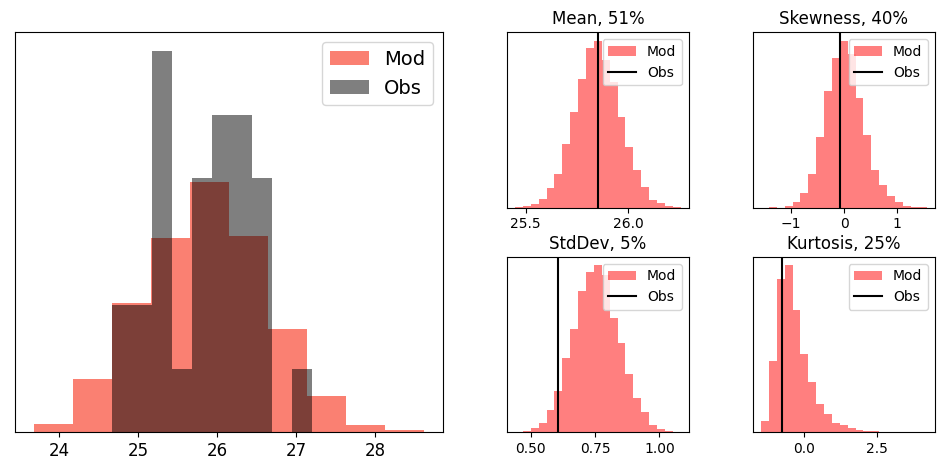

In [30]:
# temperature
stats_measures_temp_cor=timeseries_fid_test(tem_obs,mod_corrected_eigen[:,:,1])
plot_fidelity_testing(tem_obs, mod_corrected_eigen[:,:,1], stats_measures_temp_cor, 0.1,"","1.png")

In [31]:
mod_mean_boost_corr=stats_measures_temp_cor[1]["mean"]
print("original model mean (100 sample)", np.mean(tem_mod4))
print("corrected model mean (100 sample,left plot)", np.mean(mod_corrected_eigen[:,:,1]))
print("boostrapped corrected model mean (10000 sample,right plot):",np.mean(mod_mean_boost_corr))
print("observed mean, left blash line",tem_obs.mean())

original model mean (100 sample) 27.05304104789102
corrected model mean (100 sample,left plot) 25.852407660620056
boostrapped corrected model mean (10000 sample,right plot): 25.85147447688586
observed mean, left blash line 25.852407660620063


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 50.91
Standard deviation perc: 68.7
Skewness perc: 83.35000000000001
Kurtosis perc: 4.63
Linear trend perc: 0.76
plotting


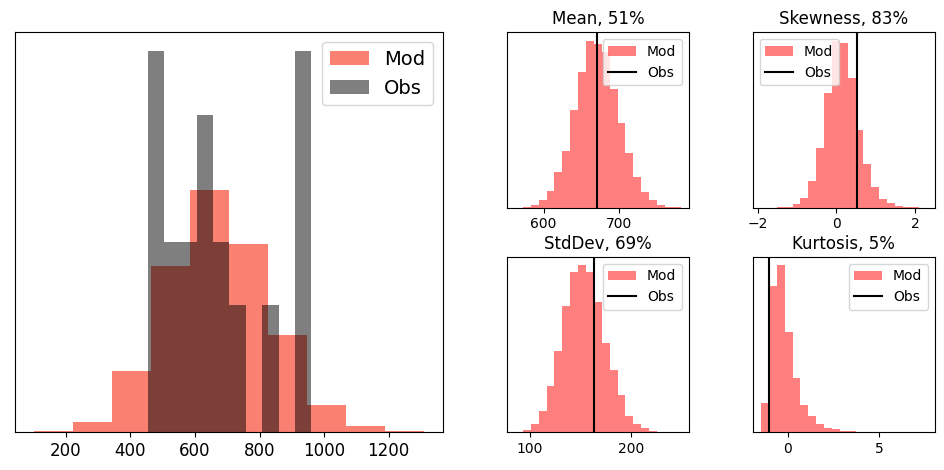

In [32]:
# precipitation
stats_measures_pr_cor=timeseries_fid_test(pr_obs,mod_corrected_eigen[:,:,0])
plot_fidelity_testing(pr_obs, mod_corrected_eigen[:,:,0], stats_measures_pr_cor, 0.1,"","1.png")

## Boostrapping: Fidelity test for multivariate data

In [35]:
def calcDistrStatistic(obs, mod_corrected, n_samples=10000, n_months=1):
    nyrs, n_members, _ = mod_corrected.shape
    # Observed statistics
    obs_means = np.mean(obs, axis=0)
    obs_stds = np.std(obs, axis=0)
    obs_corr = np.corrcoef(obs[:, 0], obs[:, 1])[0, 1]
    obs_skewness, obs_kurtosis = mardia_skewness_kurtosis(obs)
    obs_stats_dict = {
        "Mean": obs_means,
        "Standard Deviation": obs_stds,
        "Correlation": obs_corr,
        "Skewness": obs_skewness,
        "Kurtosis": obs_kurtosis,
    }
    # Bootstrap statistics
    bootstrap_means = []
    bootstrap_stds = []
    bootstrap_corrs = []
    bootstrap_skewness = []
    bootstrap_kurtosis = []
    for _ in range(n_samples):
        model_sample = []
        for iyr in range(nyrs):
            sample_indices = random.sample(range(n_members), n_months)
            model_sample.append(mod_corrected[iyr, sample_indices, :])
        model_sample = np.concatenate(model_sample, axis=0)  # Shape: (nyrs * n_months, 2)
        means = np.mean(model_sample, axis=0)
        stds = np.std(model_sample, axis=0)
        corr = np.corrcoef(model_sample[:, 0], model_sample[:, 1])[0, 1]
        skewness, kurtosis_val = mardia_skewness_kurtosis(model_sample)
        bootstrap_means.append(means)
        bootstrap_stds.append(stds)
        bootstrap_corrs.append(corr)
        bootstrap_skewness.append(skewness)
        bootstrap_kurtosis.append(kurtosis_val)

    mod_stats_dict = {
        "Mean": np.array(bootstrap_means),
        "Standard Deviation": np.array(bootstrap_stds),
        "Correlation": np.array(bootstrap_corrs),
        "Skewness": np.array(bootstrap_skewness),
        "Kurtosis": np.array(bootstrap_kurtosis),
    }
    return obs_stats_dict, mod_stats_dict

def calcPercentile(obs, model):
    """
    Parameters
    ----------
    obs : float
        Observed value.
    model : numpy array
        Modelled values.
    Returns
    -------
    percentile : float
        Percentile of observed value in model distribution.
    """
    model = sorted(model)
    ind = min(range(len(model)), key=lambda i: abs(model[i] - obs))
    percentile = ind / float(len(model)) * 100
    return percentile


In [36]:
# Calculate statistics 
n_samples = 10000
obs_stats_dict, mod_stats_dict = calcDistrStatistic(obs_combined, mod_raw, n_samples=n_samples, n_months=1)
obs_stats_dict_cor, mod_stats_dict_cor = calcDistrStatistic(obs_combined, mod_cor, n_samples=n_samples, n_months=1)
obs_stats_dict_eigen, mod_stats_dict_eigen = calcDistrStatistic(obs_combined, mod_corrected_eigen, n_samples=n_samples, n_months=1)

# Calculate percentiles -- --original model
mean_perc = [calcPercentile(obs_stats_dict["Mean"][i], mod_stats_dict["Mean"][:, i]) for i in range(2)]
std_perc = [calcPercentile(obs_stats_dict["Standard Deviation"][i], mod_stats_dict["Standard Deviation"][:, i]) for i in range(2)]
corr_perc = calcPercentile(obs_stats_dict["Correlation"], mod_stats_dict["Correlation"])
skew_perc = calcPercentile(obs_stats_dict["Skewness"], mod_stats_dict["Skewness"])
kurt_perc = calcPercentile(obs_stats_dict["Kurtosis"], mod_stats_dict["Kurtosis"])

# Calculate percentiles --mean shifted model
mean_perc_cor = [calcPercentile(obs_stats_dict["Mean"][i], mod_stats_dict_cor["Mean"][:, i]) for i in range(2)]
std_perc_cor = [calcPercentile(obs_stats_dict["Standard Deviation"][i], mod_stats_dict_cor["Standard Deviation"][:, i]) for i in range(2)]
corr_perc_cor = calcPercentile(obs_stats_dict["Correlation"], mod_stats_dict_cor["Correlation"])
skew_perc_cor = calcPercentile(obs_stats_dict["Skewness"], mod_stats_dict_cor["Skewness"])
kurt_perc_cor = calcPercentile(obs_stats_dict["Kurtosis"], mod_stats_dict_cor["Kurtosis"])

# Calculate percentiles --mean and corr corrected model
mean_perc_eigen = [calcPercentile(obs_stats_dict["Mean"][i], mod_stats_dict_eigen["Mean"][:, i]) for i in range(2)]
std_perc_eigen = [calcPercentile(obs_stats_dict["Standard Deviation"][i], mod_stats_dict_eigen["Standard Deviation"][:, i]) for i in range(2)]
corr_perc_eigen = calcPercentile(obs_stats_dict["Correlation"], mod_stats_dict_eigen["Correlation"])
skew_perc_eigen = calcPercentile(obs_stats_dict["Skewness"], mod_stats_dict_eigen["Skewness"])
kurt_perc_eigen = calcPercentile(obs_stats_dict["Kurtosis"], mod_stats_dict_eigen["Kurtosis"])

In [37]:
def plot_single_variable_comparison(
    obs_stats, mod_stats, mod_stats_cor, mod_stats_eigen,
    percentiles, percentiles_cor, percentiles_eigen,
    statistic_key, variable_name, color,variable
):
    """
    Parameters
    ----------
    obs_stats : dict
        Observed statistics dictionary.
    mod_stats : dict
        Original model statistics dictionary.
    mod_stats_cor : dict
        Mean corrected model statistics dictionary.
    mod_stats_eigen : dict
        Mean and Correlation corrected model statistics dictionary.
    percentiles : list
        Percentiles for observed statistics in mod distribution.
    percentiles_cor : list
        Percentiles for observed statistics in mod_cor distribution.
    percentiles_eigen : list
        Percentiles for observed statistics in mod_corrected_eigen distribution.
    statistic_key : str
        Key for the statistic to plot (e.g., 'mean', 'std').
    variable_name : str
        Name of the variable (e.g., 'Precipitation').
    color : str
        Color for the histogram.
    """
    datasets = [
        ("Original Model", mod_stats, percentiles),
        ("Mean Shifted Model", mod_stats_cor, percentiles_cor),
        ("Mean and Correlation Corrected Model", mod_stats_eigen, percentiles_eigen),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    for j, (label, stats_dict, percentiles_set) in enumerate(datasets):  # Loop over datasets
        ax = axes[j]
        obs_stat = obs_stats[statistic_key][variable]  # Only for the specified variable(0 - pr, 1 - temp)
        model_stat = stats_dict[statistic_key][:, variable]  # Only for the specified variable
        # Plot the distribution for the model statistic
        ax.hist(
            model_stat,
            bins=30,
            density=True,
            alpha=0.5,
            histtype="stepfilled",
            color=color[j],
            label=f"Model {statistic_key.capitalize()}",
        )
        ax.axvline(
            obs_stat,
            color="k",
            linestyle="--",
            label=(
                f"Observed {statistic_key.capitalize()}: {obs_stat:.2f}\n"
                f"(Percentile: {percentiles_set[0]:.2f}%)"
            ),
        )
        ax.set_title(label, fontsize=12)
        ax.set_xlabel(f"{statistic_key.capitalize()} of {variable_name}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"{variable_name} Density", fontsize=12)
        ax.legend(loc="upper right", fontsize=11)
    plt.tight_layout()
    plt.show()

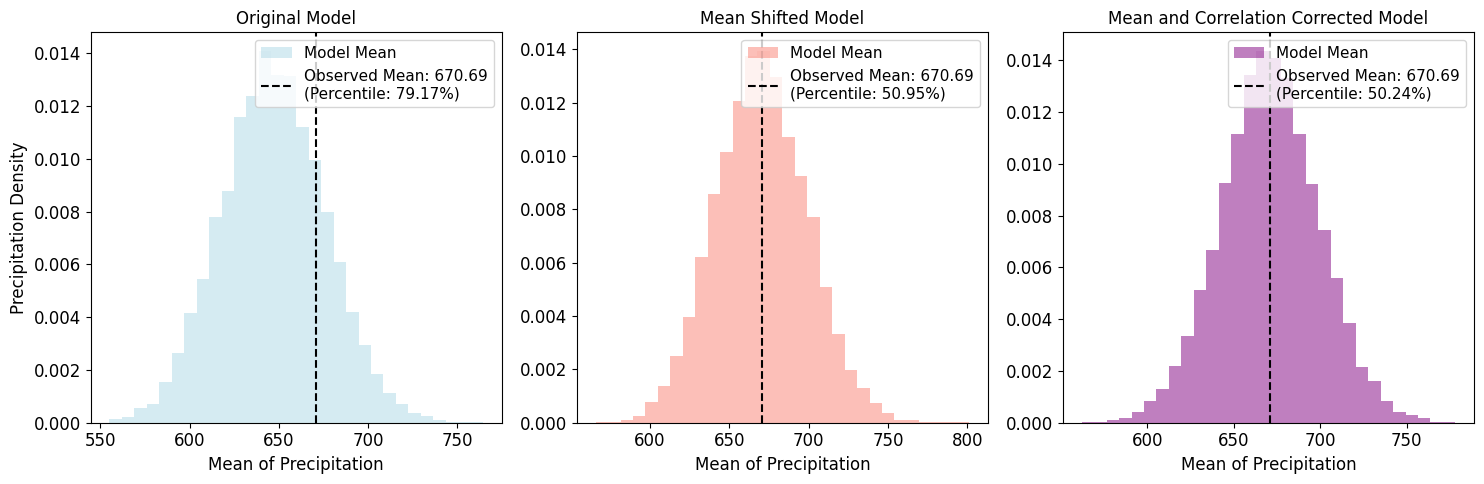

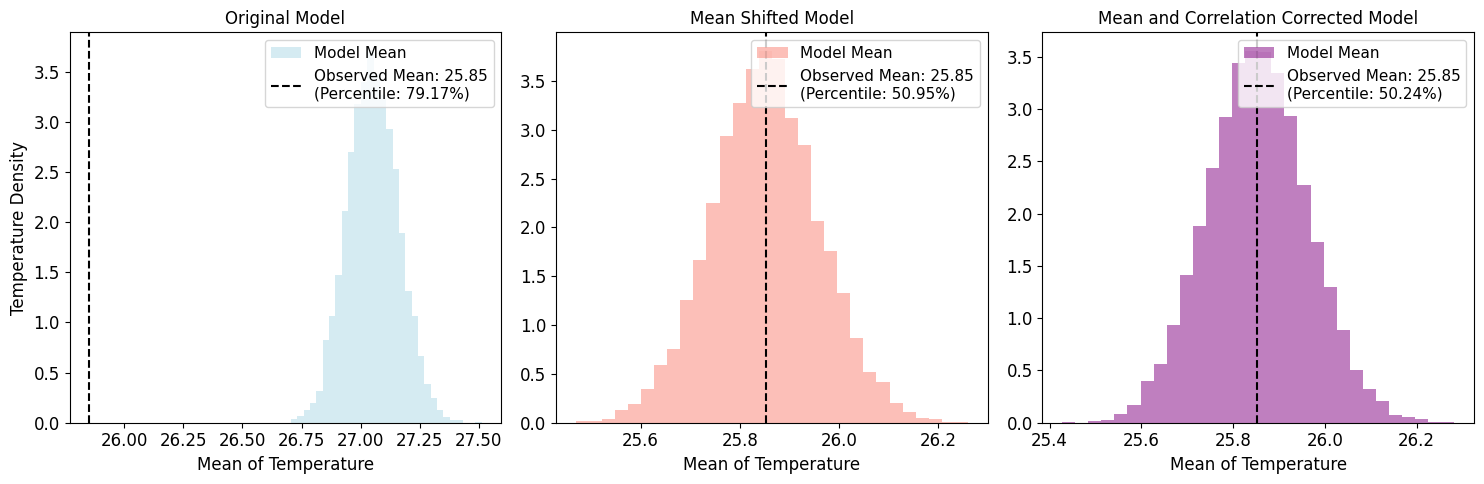

In [38]:
# mean comparison
plot_single_variable_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentiles=mean_perc,
    percentiles_cor=mean_perc_cor,
    percentiles_eigen=mean_perc_eigen,
    statistic_key="Mean",
    variable_name="Precipitation",
    color=["lightblue",'salmon','purple'],
    variable = 0
)
plot_single_variable_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentiles=mean_perc,
    percentiles_cor=mean_perc_cor,
    percentiles_eigen=mean_perc_eigen,
    statistic_key="Mean",
    variable_name="Temperature",
    color=["lightblue",'salmon','purple'],
    variable = 1
)

In [39]:
# for original model data
print("original model mean (100 sample)",mod_raw[:,:,1].mean())
print("boostrapped model mean:",mod_stats_dict["Mean"][:,1].mean())
print("obs mean:",obs_combined[:,1].mean())

original model mean (100 sample) 27.05304104789102
boostrapped model mean: 27.052285981473787
obs mean: 25.852407660620063


In [40]:
# for mean corrected model data
print("original model mean (100 sample)",mod_cor[:,:,1].mean())
print("boostrapped model mean:",mod_stats_dict_cor["Mean"][:,1].mean())
print("obs mean:",obs_combined[:,1].mean())

original model mean (100 sample) 25.852407660620063
boostrapped model mean: 25.851746519866232
obs mean: 25.852407660620063


In [41]:
# for mean and correlation corrected model data:
print("original model mean (100 sample)",mod_corrected_eigen[:,:,1].mean())
print("boostrapped model mean:",mod_stats_dict_eigen["Mean"][:,1].mean())
print("obs mean:",obs_combined[:,1].mean())

original model mean (100 sample) 25.852407660620056
boostrapped model mean: 25.852774390721052
obs mean: 25.852407660620063


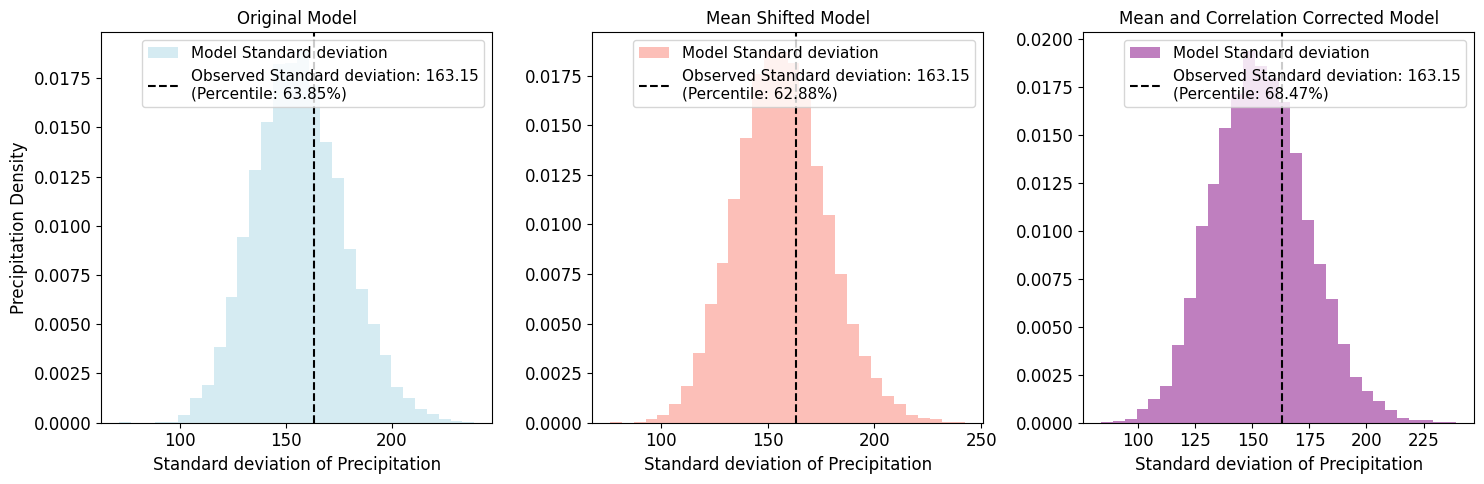

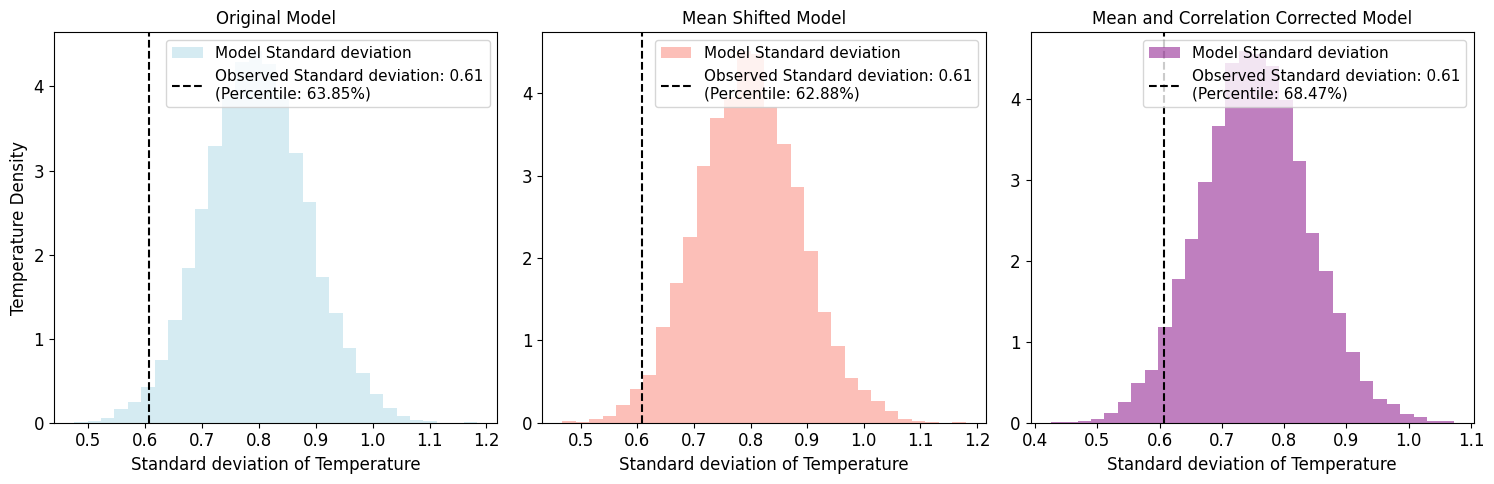

In [42]:
#std comparison
plot_single_variable_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentiles=std_perc,
    percentiles_cor=std_perc_cor,
    percentiles_eigen=std_perc_eigen,
    statistic_key="Standard Deviation",
    variable_name="Precipitation",
    color=["lightblue",'salmon','purple'],
    variable = 0
)
plot_single_variable_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentiles=std_perc,
    percentiles_cor=std_perc_cor,
    percentiles_eigen=std_perc_eigen,
    statistic_key="Standard Deviation",
    variable_name="Temperature",
    color=["lightblue",'salmon','purple'],
    variable = 1
)

In [43]:
# for corr, skewness, and kurtosis
def plot_corr_skew_kurtosis_comparison(
    obs_stats, mod_stats, mod_stats_cor, mod_stats_eigen,
    percentile, percentile_cor, percentile_eigen,
    statistic_key, color
):
    datasets = [
        ("Original Model", mod_stats, percentile),
        ("Mean Shifted Model", mod_stats_cor, percentile_cor),
        ("Mean and Correlation Corrected Model", mod_stats_eigen, percentile_eigen),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    for j, (label, stats_dict, percentile_val) in enumerate(datasets): 
        ax = axes[j]

        obs_stat = obs_stats[statistic_key] 
        model_stat = stats_dict[statistic_key] 
        ax.hist(
            model_stat,
            bins=30,
            density=True,
            alpha=0.5,
            histtype="stepfilled",
            color=color[j],
            label=f"Model {statistic_key.capitalize()}",
        )
        ax.axvline(
            obs_stat,
            color="k",
            linestyle="--",
            label=(
                f"Observed {statistic_key.capitalize()}: {obs_stat:.2f}\n"
                f"(Percentile: {percentile_val:.2f}%)"
            ),
        )
        ax.set_title(label, fontsize=12)
        ax.set_xlabel(f"{statistic_key.capitalize()}", fontsize=13)
        if j == 0:
            ax.set_ylabel("Density", fontsize=13)
        ax.legend(loc="upper right", fontsize=11)
    plt.tight_layout()
    plt.show()

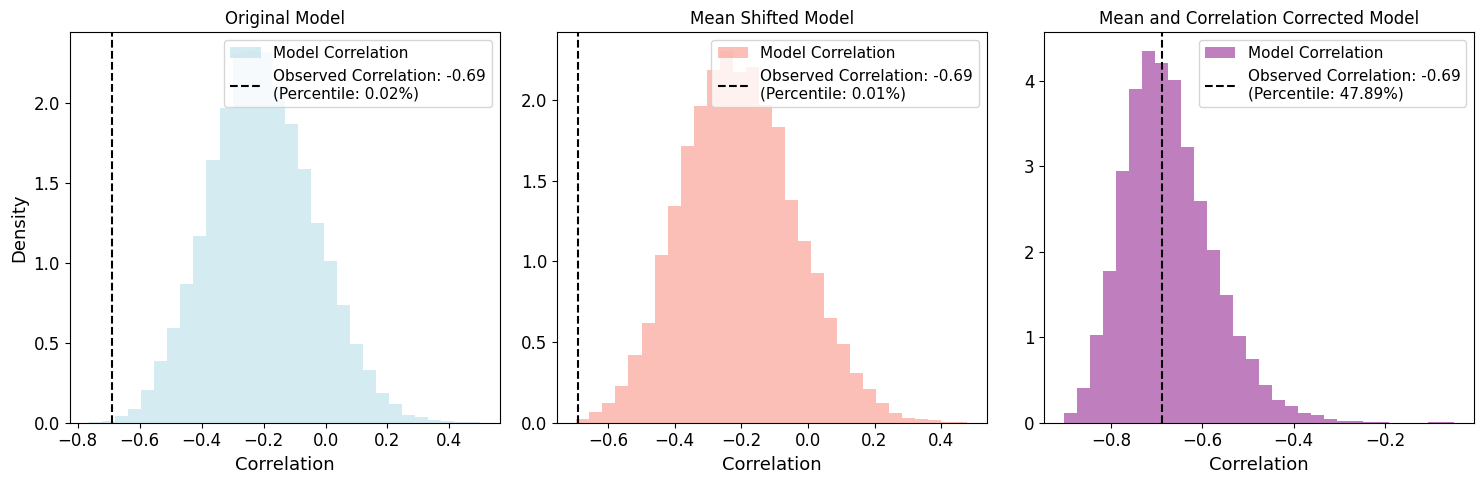

In [44]:
# Correlation comparison
plot_corr_skew_kurtosis_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentile=corr_perc,
    percentile_cor=corr_perc_cor,
    percentile_eigen=corr_perc_eigen,
    statistic_key="Correlation",
    color=["lightblue",'salmon','purple'],
)

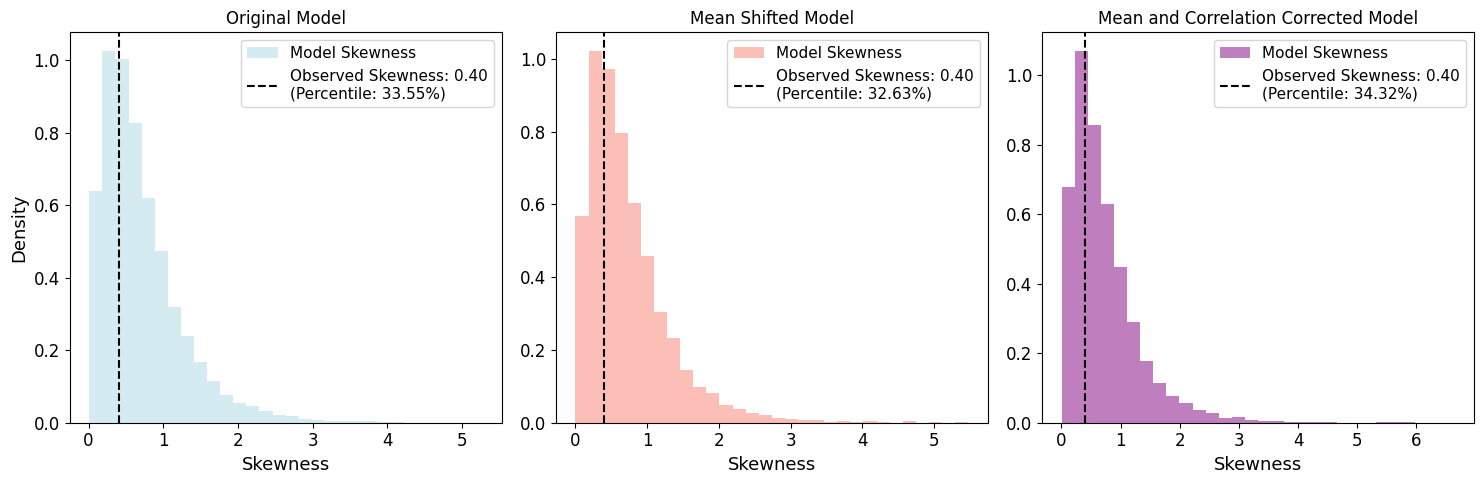

In [45]:
# Skewness comparison
plot_corr_skew_kurtosis_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentile=skew_perc,
    percentile_cor=skew_perc_cor,
    percentile_eigen=skew_perc_eigen,
    statistic_key="Skewness",
    color=["lightblue",'salmon','purple'],
)

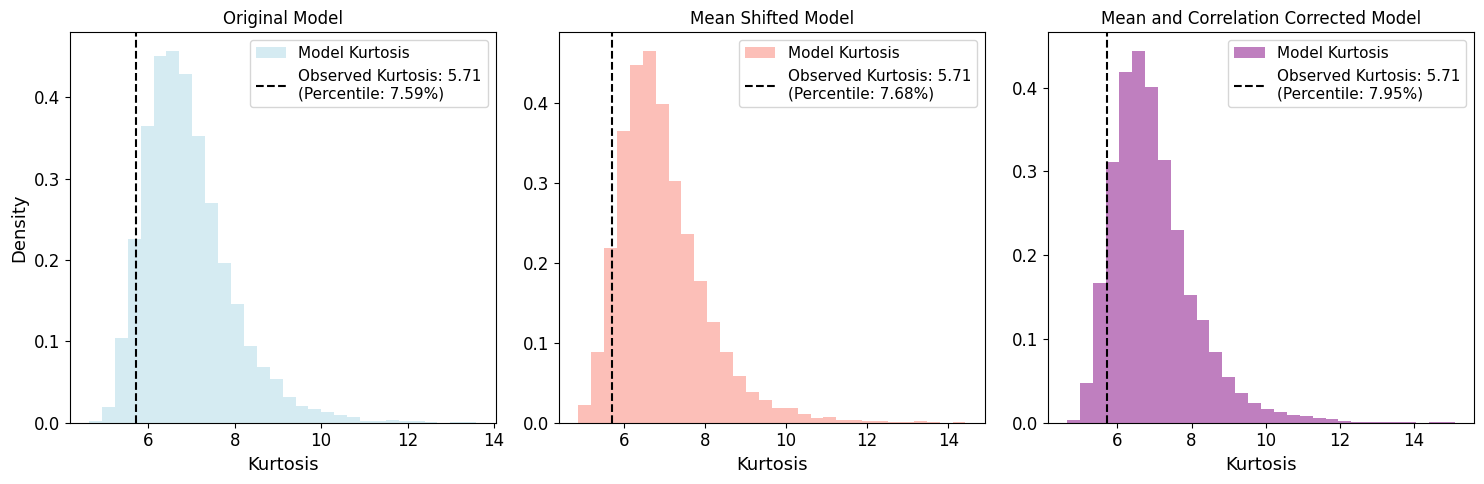

In [46]:
# Kurtosis Comparison
plot_corr_skew_kurtosis_comparison(
    obs_stats=obs_stats_dict,
    mod_stats=mod_stats_dict,
    mod_stats_cor=mod_stats_dict_cor,
    mod_stats_eigen=mod_stats_dict_eigen,
    percentile=kurt_perc,
    percentile_cor=kurt_perc_cor,
    percentile_eigen=kurt_perc_eigen,
    statistic_key="Kurtosis",
    color=["lightblue",'salmon','purple'],
)

## SVM

In [47]:
def compare_with_svm(obs_data, mod_data):
    X = np.vstack((obs_data, mod_data))  
    y = np.hstack((np.zeros(obs_data.shape[0]), np.ones(mod_data.shape[0])))  
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    svm_model = svm.SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_scaled, y)
    y_scores = svm_model.decision_function(X_scaled)
    obs_decision_mean = np.mean(y_scores[:obs_data.shape[0]])
    mod_decision_mean = np.mean(y_scores[obs_data.shape[0]:])
    y_pred = svm_model.predict(X_scaled)
    accuracy = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, svm_model.predict_proba(X_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    return accuracy, obs_decision_mean, mod_decision_mean, fpr, tpr, roc_auc

In [48]:
def SVM_plot(obs_combined,mod_cor):
    
    obs_data = obs_combined
    num_ensembles = mod_cor.shape[1]

    results = [compare_with_svm(obs_data, mod_cor[:, i, :]) for i in range(num_ensembles)]
    accuracies, obs_means, mod_means, fprs, tprs, aucs = zip(*results)

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = []
    for fpr, tpr in zip(fprs, tprs):
        interp_tprs.append(np.interp(mean_fpr, fpr, tpr))
        interp_tprs[-1][0] = 0.0
        plt.plot(fpr, tpr, color='lightblue', alpha=0.1)
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_tpr = np.std(interp_tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.subplot(132)
    plt.hist(accuracies, bins=20, edgecolor='black')
    plt.axvline(np.mean(accuracies), color='r', linestyle='dashed', linewidth=2)
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title('Distribution of Accuracies')

    print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

Mean Accuracy: 0.8493 ± 0.0549
Mean AUC: 0.9210 ± 0.0359


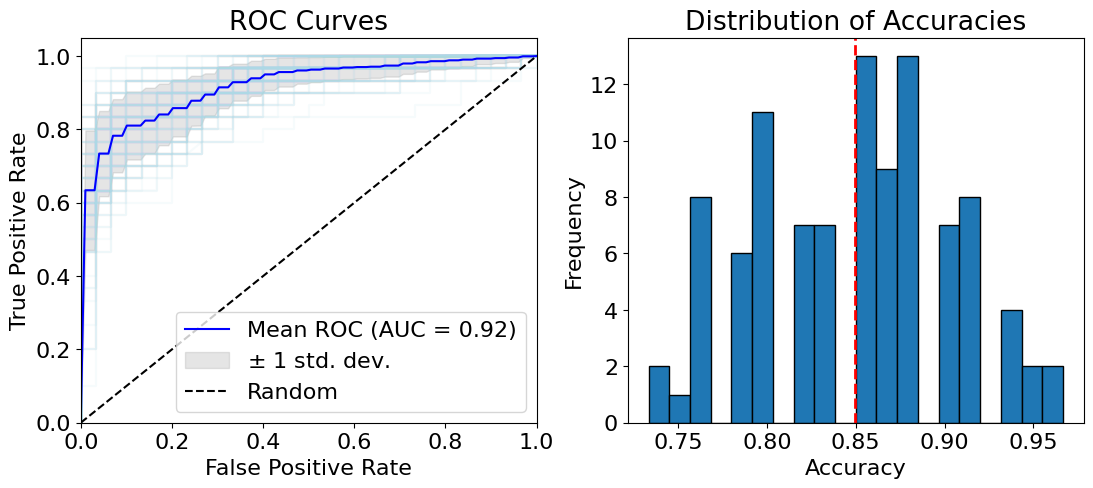

In [64]:
SVM_plot(obs_combined,mod_raw)

Mean Accuracy: 0.6977 ± 0.0370
Mean AUC: 0.7228 ± 0.1628


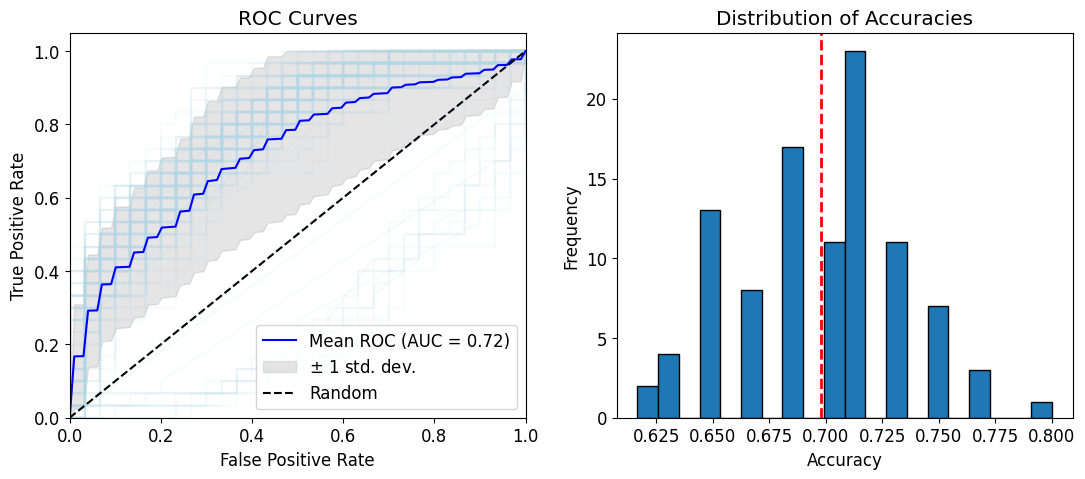

In [50]:
SVM_plot(obs_combined,mod_cor)

Mean Accuracy: 0.6543 ± 0.0474
Mean AUC: 0.5155 ± 0.2140


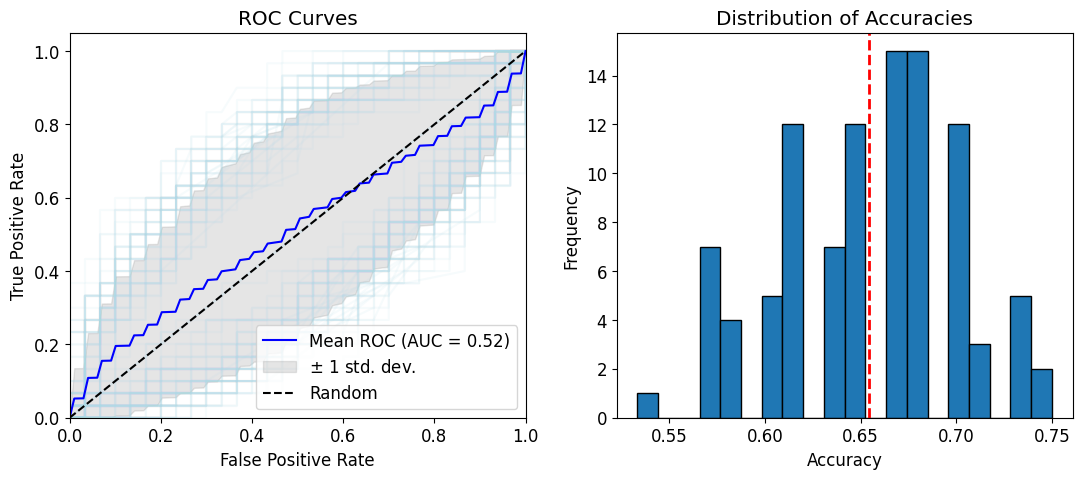

In [51]:
SVM_plot(obs_combined,mod_corrected_eigen)

## Probability

In [52]:
from matplotlib.lines import Line2D
from matplotlib import rcParams
def plot_comparison(obs, mod_original, mod_corrected, model_corrected_eigen):
    rcParams['font.size'] = 16
    obs_extreme_temp = obs[:, 1].max()  # Max temperature
    obs_extreme_precip = obs[:, 0].min()  # Min precipitation
    mod_original_flat = mod_original.reshape(-1, 2)
    mod_corrected_flat = mod_corrected.reshape(-1, 2)
    mod_eigen_flat = model_corrected_eigen.reshape(-1, 2)

    # Identify exceeding events for each model
    mod_original_exceeding = mod_original_flat[
        (mod_original_flat[:, 1] >= obs_extreme_temp) | (mod_original_flat[:, 0] <= obs_extreme_precip)
    ]
    mod_corrected_exceeding = mod_corrected_flat[
        (mod_corrected_flat[:, 1] >= obs_extreme_temp) | (mod_corrected_flat[:, 0] <= obs_extreme_precip)
    ]
    mod_eigen_exceeding = mod_eigen_flat[
        (mod_eigen_flat[:, 1] >= obs_extreme_temp) | (mod_eigen_flat[:, 0] <= obs_extreme_precip)
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.kdeplot(x=obs[:, 1], y=obs[:, 0], cmap="Blues", fill=True, alpha=0.6, ax=axes[0], label="Observations")
    sns.kdeplot(x=mod_original_flat[:, 1], y=mod_original_flat[:, 0], cmap="Oranges", fill=True, alpha=0.4, ax=axes[0])
    axes[0].axvline(obs_extreme_temp, color="blue", linestyle="--", linewidth=1.5)
    axes[0].axhline(obs_extreme_precip, color="green", linestyle="--", linewidth=1.5)
    axes[0].scatter(mod_original_exceeding[:, 1], mod_original_exceeding[:, 0], color="red", alpha=0.6)
    axes[0].set_title("Obs vs. Original Model")
    axes[0].set_xlabel("Temperature")
    axes[0].set_ylabel("Precipitation")

    sns.kdeplot(x=obs[:, 1], y=obs[:, 0], cmap="Blues", fill=True, alpha=0.6, ax=axes[1])
    sns.kdeplot(x=mod_corrected_flat[:, 1], y=mod_corrected_flat[:, 0], cmap="Oranges", fill=True, alpha=0.4, ax=axes[1])
    axes[1].axvline(obs_extreme_temp, color="blue", linestyle="--", linewidth=1.5)
    axes[1].axhline(obs_extreme_precip, color="green", linestyle="--", linewidth=1.5)
    axes[1].scatter(mod_corrected_exceeding[:, 1], mod_corrected_exceeding[:, 0], color="red", alpha=0.6)
    axes[1].set_title("Obs vs. Mean Corrected Model")
    axes[1].set_xlabel("Temperature")
    axes[1].set_ylabel("Precipitation")

    sns.kdeplot(x=obs[:, 1], y=obs[:, 0], cmap="Blues", fill=True, alpha=0.6, ax=axes[2])
    sns.kdeplot(x=mod_eigen_flat[:, 1], y=mod_eigen_flat[:, 0], cmap="Oranges", fill=True, alpha=0.4, ax=axes[2])
    axes[2].axvline(obs_extreme_temp, color="blue", linestyle="--", linewidth=1.5)
    axes[2].axhline(obs_extreme_precip, color="green", linestyle="--", linewidth=1.5)
    axes[2].scatter(mod_eigen_exceeding[:, 1], mod_eigen_exceeding[:, 0], color="red", alpha=0.6)
    axes[2].set_title("Obs vs. Mean and Corr Corrected Model")
    axes[2].set_xlabel("Temperature")
    axes[2].set_ylabel("Precipitation")
    custom_lines = [
        Line2D([0], [0], color="blue", linestyle="--", lw=1.5, label="Observed Temp Extreme"),
        Line2D([0], [0], color="green", linestyle="--", lw=1.5, label="Observed Precip Extreme"),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=13, label="Record-breaking Events"),
    ]
    fig.legend(handles=custom_lines, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout()
    plt.show()

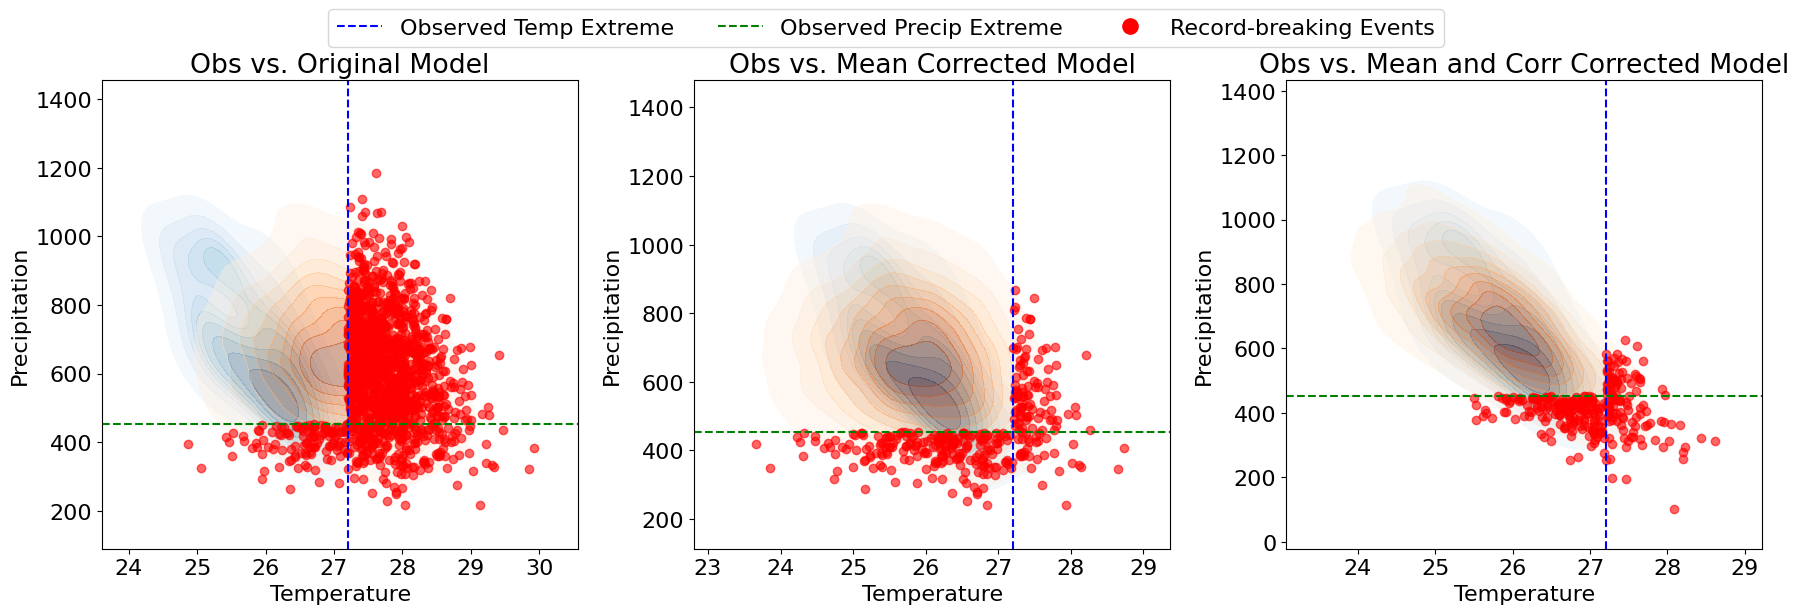

In [53]:
plot_comparison(obs_combined,mod_raw, mod_cor,mod_corrected_eigen)

In [54]:
def calculate_and_compare_probabilities(obs, mod_original, mod_corrected, mod_corrected_eigen):
    """
    Calculate and compare probabilities of hot and dry events for original, corrected, and eigen-corrected models.
    """
    obs_extreme_precip = obs[:, 0].min()  # Minimum precipitation
    obs_extreme_temp = obs[:, 1].max()  # Maximum temperature

    mod_original_flat = mod_original.reshape(-1, 2)
    mod_corrected_flat = mod_corrected.reshape(-1, 2)
    mod_corrected_eigen_flat = mod_corrected_eigen.reshape(-1, 2)
    dry_original_count = np.sum(mod_original_flat[:, 0] <= obs_extreme_precip)
    hot_original_count = np.sum(mod_original_flat[:, 1] >= obs_extreme_temp)
    total_original_count = len(mod_original_flat)
    P_dry_original = dry_original_count / total_original_count
    P_hot_original = hot_original_count / total_original_count
    dry_corrected_count = np.sum(mod_corrected_flat[:, 0] <= obs_extreme_precip)
    hot_corrected_count = np.sum(mod_corrected_flat[:, 1] >= obs_extreme_temp)
    total_corrected_count = len(mod_corrected_flat)
    P_dry_corrected = dry_corrected_count / total_corrected_count
    P_hot_corrected = hot_corrected_count / total_corrected_count
    dry_corrected_eigen_count = np.sum(mod_corrected_eigen_flat[:, 0] <= obs_extreme_precip)
    hot_corrected_eigen_count = np.sum(mod_corrected_eigen_flat[:, 1] >= obs_extreme_temp)
    total_corrected_eigen_count = len(mod_corrected_eigen_flat)
    P_dry_corrected_eigen = dry_corrected_eigen_count / total_corrected_eigen_count
    P_hot_corrected_eigen = hot_corrected_eigen_count / total_corrected_eigen_count
    labels = ['Dry', 'Hot']
    original_probs = [P_dry_original, P_hot_original]
    corrected_probs = [P_dry_corrected, P_hot_corrected]
    eigen_corrected_probs = [P_dry_corrected_eigen, P_hot_corrected_eigen]
    x = np.arange(len(labels))
    width = 0.2
    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width, original_probs, width, label='Original Mod', color='orange')
    bars2 = ax.bar(x, corrected_probs, width, label='Mean shift Mod', color='lightblue')
    bars3 = ax.bar(x + width, eigen_corrected_probs, width, label='Mean and Corr corrected Mod', color='green')
    ax.set_ylabel('Probability')
    #ax.set_title('Probability Comparison of Dry and Hot Events')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points above bar
                        textcoords="offset points",
                        ha='center', va='bottom')
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    plt.tight_layout()
    plt.show()

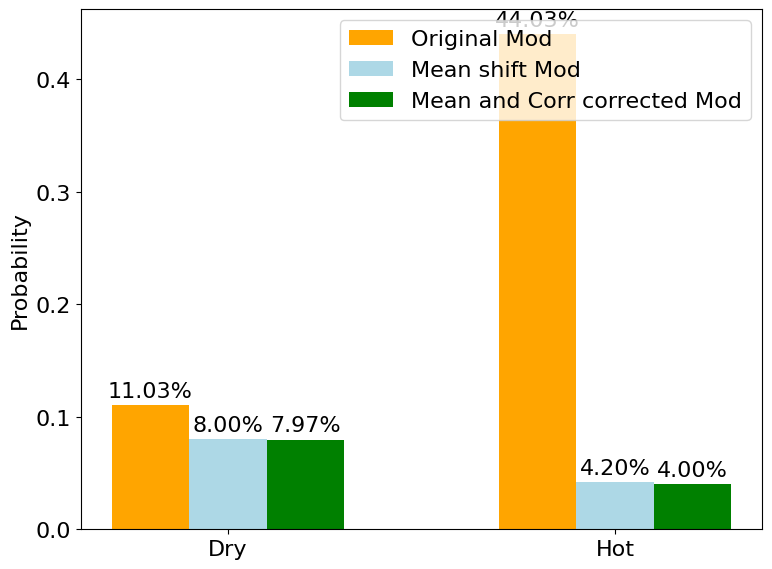

In [55]:
calculate_and_compare_probabilities(obs_combined, mod_raw,mod_cor, mod_corrected_eigen)

In [56]:
def calculate_and_compare_joint_probabilities(obs, mod_original, mod_corrected, mod_corrected_eigen):
    """
    Calculate and compare joint probabilities of extreme events for original, corrected, and eigen-corrected models.
    """
    obs_extreme_precip = obs[:, 0].min()  # Minimum precipitation
    obs_extreme_temp = obs[:, 1].max()  # Maximum temperature
    mod_original_flat = mod_original.reshape(-1, 2)
    mod_corrected_flat = mod_corrected.reshape(-1, 2)
    mod_corrected_eigen_flat = mod_corrected_eigen.reshape(-1, 2)

    joint_original_count = np.sum(
        (mod_original_flat[:, 0] <= obs_extreme_precip) & (mod_original_flat[:, 1] >= obs_extreme_temp)
    )
    total_original_count = len(mod_original_flat)
    P_joint_original = joint_original_count / total_original_count

    joint_corrected_count = np.sum(
        (mod_corrected_flat[:, 0] <= obs_extreme_precip) & (mod_corrected_flat[:, 1] >= obs_extreme_temp)
    )
    total_corrected_count = len(mod_corrected_flat)
    P_joint_corrected = joint_corrected_count / total_corrected_count

    joint_corrected_eigen_count = np.sum(
        (mod_corrected_eigen_flat[:, 0] <= obs_extreme_precip) & (mod_corrected_eigen_flat[:, 1] >= obs_extreme_temp)
    )
    total_corrected_eigen_count = len(mod_corrected_eigen_flat)
    P_joint_corrected_eigen = joint_corrected_eigen_count / total_corrected_eigen_count
    labels = ['High Temp & Low Precip']
    joint_probs = [P_joint_original, P_joint_corrected, P_joint_corrected_eigen]
    x = np.arange(len(labels))
    width = 0.2
    fig, ax = plt.subplots(figsize=(6, 5))
    bars1 = ax.bar(x - width, [P_joint_original], width, label='Original Mod', color='orange', edgecolor='black')
    bars2 = ax.bar(x, [P_joint_corrected], width, label='Mean shift Mod', color='lightblue', edgecolor='black')
    bars3 = ax.bar(x + width, [P_joint_corrected_eigen], width, label='Mean and Corr Corrected Mod', color='green', edgecolor='black')
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.set_title('Joint Probability of High Temp & Low Precip')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8, color='black', fontweight='bold')
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    plt.tight_layout()
    plt.show()

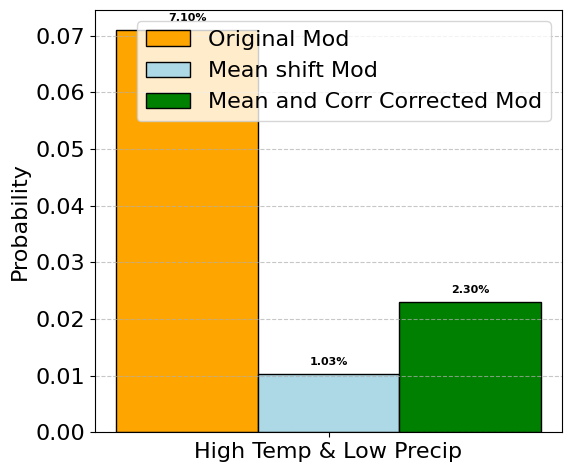

In [57]:
# dry and hot condition
calculate_and_compare_joint_probabilities(obs_combined, mod_raw, mod_cor, mod_corrected_eigen)

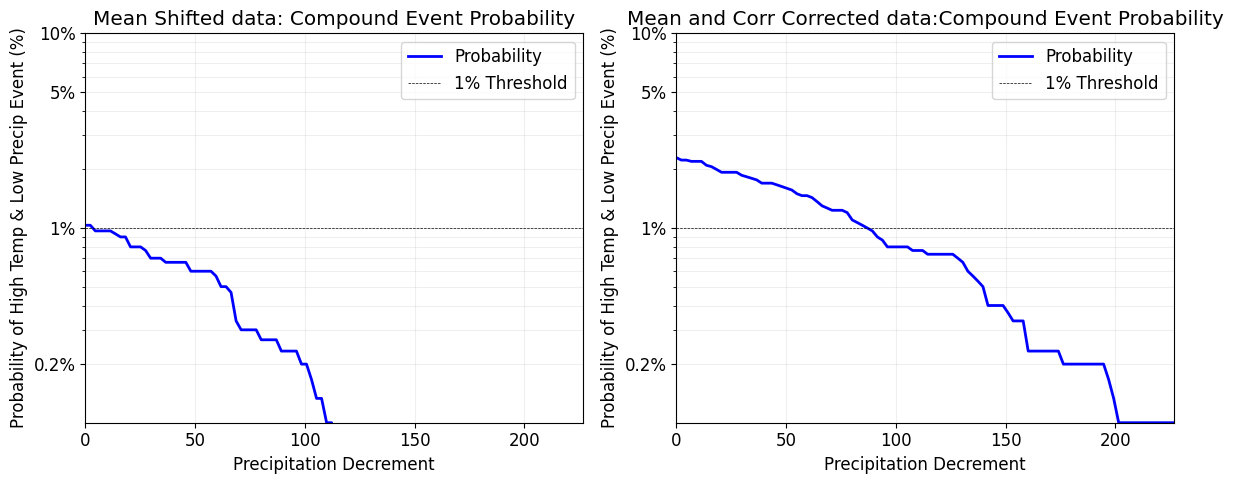

In [73]:
def calculate_below_minimum_compound_probability(data, temp_threshold, precip_threshold, precip_decrements):
    probs = []
    for precip_dec in precip_decrements:
        prob = np.mean((data[:, :, 1] >= temp_threshold) & 
                       (data[:, :, 0] <= (precip_threshold - precip_dec))) * 100
        probs.append(prob)
    return probs

def plot_below_minimum_compound_probability(ax, mod, obs, title):
    rcParams['font.size'] = 12
    obs_min_precip = np.min(obs[:, 0])
    obs_high_temp = np.percentile(obs[:, 1], 100)  # 90% temperature as threshold
    max_precip_decrement = obs_min_precip * 0.5  #(minimum pr - 50% minumum pr)
    precip_decrements = np.linspace(0, max_precip_decrement, 100)
    probabilities = calculate_below_minimum_compound_probability(mod, obs_high_temp, obs_min_precip, precip_decrements)
    ax.plot(precip_decrements, probabilities, color='blue', linewidth=2, label="Probability")
    ax.set_xlabel('Precipitation Decrement')
    ax.set_ylabel('Probability of High Temp & Low Precip Event (%)')
    ax.set_yscale('log')
    ax.set_ylim(0.1, 10)
    ax.set_xlim(0, max_precip_decrement)
    ax.set_yticks([0.2, 1, 5, 10])
    ax.set_yticklabels(['0.2%', '1%', '5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5, label="1% Threshold")
    ax.legend()    
    return probabilities, precip_decrements

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
prob1, precip_decrements1 = plot_below_minimum_compound_probability(ax1, mod_cor, obs_combined, 'Mean Shifted data: Compound Event Probability')
prob2, precip_decrements2 = plot_below_minimum_compound_probability(ax2, mod_corrected_eigen, obs_combined, 'Mean and Corr Corrected data:Compound Event Probability')
plt.tight_layout()
plt.show()

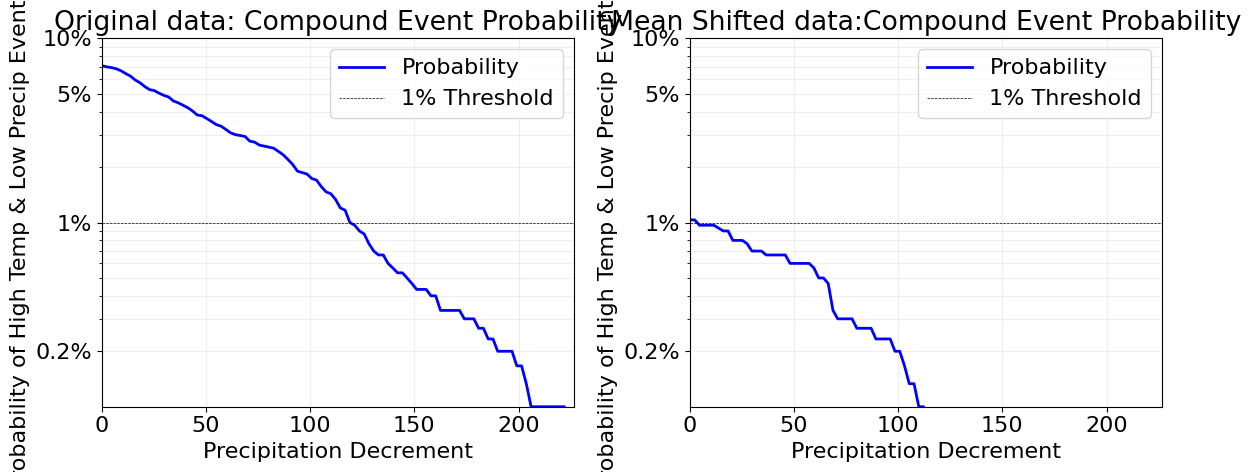

In [59]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
prob1, precip_decrements1 = plot_below_minimum_compound_probability(ax1, mod_raw, obs_combined, 'Original data: Compound Event Probability')
prob2, precip_decrements2 = plot_below_minimum_compound_probability(ax2, mod_cor, obs_combined, 'Mean Shifted data:Compound Event Probability')
plt.tight_layout()
plt.show()

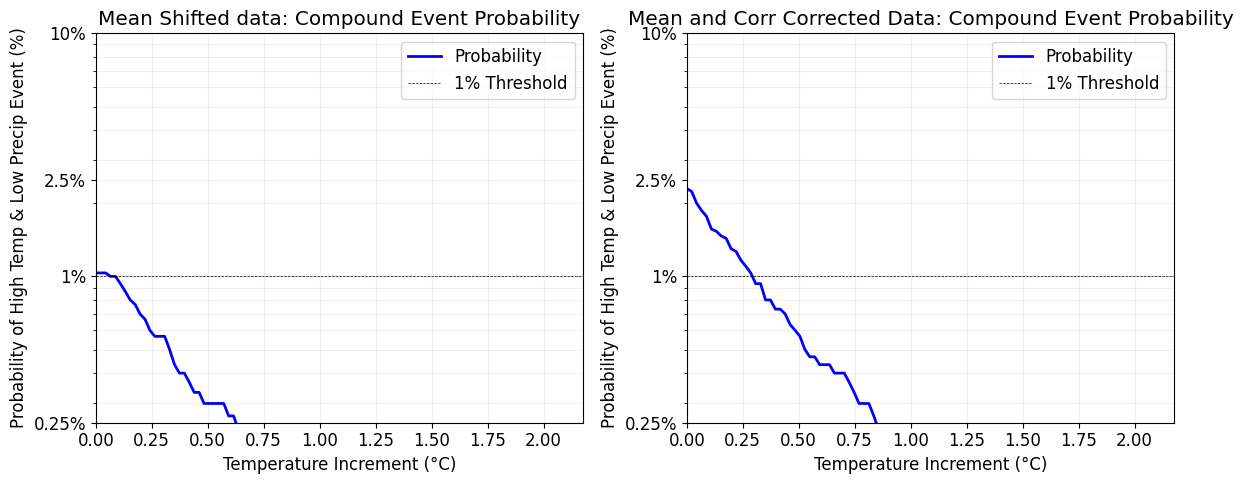

In [72]:
def prob_compound_probability_bytemp(data, precip_threshold, temp_threshold, temp_increments):
    """
    probability of "high temperature and low precipitation" when increasing temperatures
    """
    probs = []
    for temp_inc in temp_increments:
        prob = np.mean((data[:, :, 1] >= (temp_threshold + temp_inc)) & 
                       (data[:, :, 0] <= precip_threshold)) * 100
        probs.append(prob)
    return probs

def plot_compound_probability_bytemp(ax, mod, obs, title):
    obs_min_precip = np.min(obs[:, 0])
    obs_max_temp = np.percentile(np.max(obs[:, 1]), 100)
    max_temp_increment = obs_max_temp * 0.08
    temp_increments = np.linspace(0, max_temp_increment, 100)
    probabilities = prob_compound_probability_bytemp(mod, obs_min_precip, obs_max_temp, temp_increments)
    #plot
    ax.plot(temp_increments, probabilities, color='blue', linewidth=2, label="Probability")
    ax.set_xlabel('Temperature Increment (°C)')
    ax.set_ylabel('Probability of High Temp & Low Precip Event (%)')
    ax.set_yscale('log')
    ax.set_ylim(0.25, 10)
    ax.set_xlim(0, max_temp_increment)
    ax.set_yticks([0.25, 1, 2.5, 10])
    ax.set_yticklabels(['0.25%', '1%', '2.5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5, label="1% Threshold")
    ax.legend()  
    return probabilities, temp_increments

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
prob1, temp_increments1 = plot_compound_probability_bytemp(ax1, mod_cor, obs_combined, 'Mean Shifted data: Compound Event Probability')
prob2, temp_increments2 = plot_compound_probability_bytemp(ax2, mod_corrected_eigen, obs_combined, 'Mean and Corr Corrected Data: Compound Event Probability')
plt.tight_layout()
plt.show()

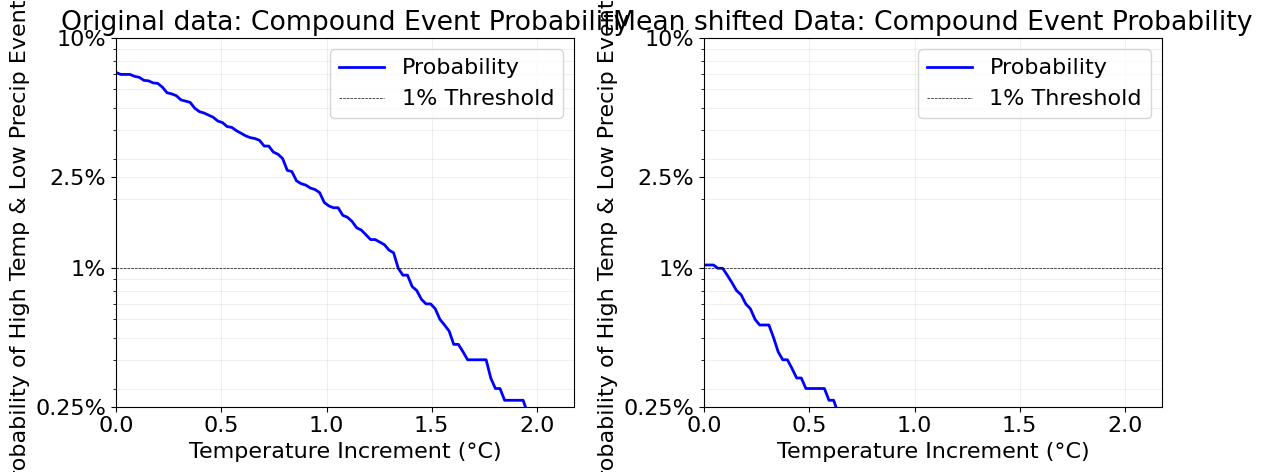

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
prob1, temp_increments1 = plot_compound_probability_bytemp(ax1, mod_raw, obs_combined, 'Original data: Compound Event Probability')
prob2, temp_increments2 = plot_compound_probability_bytemp(ax2, mod_cor, obs_combined, 'Mean shifted Data: Compound Event Probability')
plt.tight_layout()
plt.show()